# natHacks Brainflow Tutorial

Written by Harrison Fah for use in the natHacks workshop on November 8th, 2024. If you run this in Google Collab instead of Jupyter Notebook it should still work for the synthetic board but you will not be able to use your EEG device.

## Install libraries

Running this code will automatically install the libraries needed for this notebook.

## Import libraries

In [2]:
from brainflow.board_shim import BoardShim, BrainFlowInputParams, BoardIds
from brainflow.data_filter import DataFilter, FilterTypes
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
from scipy.signal import butter, lfilter, welch

## Define your device's serial port and board ID

The serial port can be found by following the instructions given in the slides.

The board ID can be found at https://brainflow.readthedocs.io/en/stable/UserAPI.html#brainflow-board-shim

In [3]:
params = BrainFlowInputParams()
params.serial_port = 'COM3' #Change this depending on your device and OS
board_id = 1 #Change this depending on your device

## Create board object

We now create the BoardShim object that allows us to interact with our device. We first try to create the object using the above parameters. We call prepare_session using the board to verify that the device is properly connected. If there is an issue with the device then it will instead create a synthetic board object. Finally we release the session from the board so that we don't run into any issues trying to prepare a session later (you can only prepare one session at a time).

In [4]:
#Prepares the board for reading data
try:
    board_id = 1
    board = BoardShim(board_id, params)
    board.prepare_session()
    print("Successfully prepared physical board.")
except Exception as e:
    print(e)
    #If the device cannot be found or is being used elsewhere, creates a synthetic board instead
    print("Device could not be found or is being used by another program, creating synthetic board.")
    board_id = BoardIds.SYNTHETIC_BOARD
    board = BoardShim(board_id, params)
    board.prepare_session()
#Releases the board session
board.release_session()

Successfully prepared physical board.


## Read data from board

Here we start a stream from the board so that we can record data from it. We first prepare the board and start the stream, then we wait 5 seconds and get the board data (clearing the buffer).

In [8]:
print("Starting Stream")
board.prepare_session()
board.start_stream()
time.sleep(1) #wait 1 seconds
data = board.get_board_data() #gets all data from board and removes it from internal buffer
print("Ending stream")
board.stop_stream()
board.release_session()
print(type(data))
print(data.shape)

Starting Stream
Ending stream


We can see from the result of the above code snippet that there are 32 channels, however the OpenBCI only has 16 channels. This is because Brainflow can also record other types of biosignals (EMG, EOG, ...). We are only interested in the EEG channels currently so we isolate the channels below.

In [31]:
#We want to isolate just the eeg data
#eeg_channels = board.get_eeg_channels(board_id)
eeg_channels = [1,2]
print(eeg_channels)
eeg_data = data[eeg_channels]
print(eeg_data.shape)
print(eeg_data)

[1, 2]
(2, 120401)
[[ 10.37822238 -19.25674487  -2.66280877 ... -92.03145811 -41.07906111
  -32.44363212]
 [ 11.16360137  -0.43756829  18.82291648 ...   0.28236245  30.12676409
   61.98323192]]


We can also find the channels for other datatypes

In [105]:
#We can also find the channels for other datatypes
#eog_channels = board.get_eog_channels(board_id)
#print(eog_channels)

Here we plot out the data from the first EEG channel across the 5 seconds

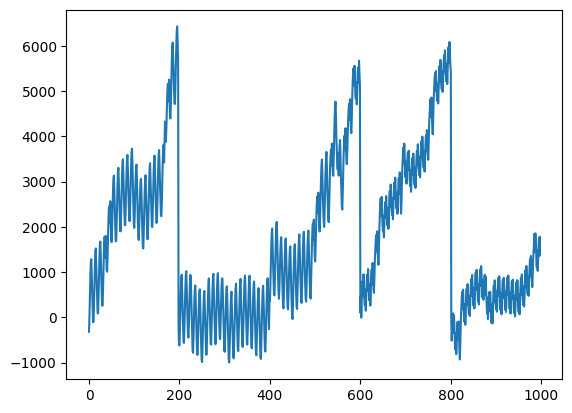

In [127]:
#Plot the first EEG channel
plt.plot(np.arange(eeg_data.shape[1]), eeg_data[0])

## Read data and insert markers

If you are dealing with any sort of stimulus or events in your EEG data, it is handy to know where exactly they occurred. Luckily, Brainflow has a function for this, allowing you to insert markers in the datastream right when events happen. These can then be accessed from the data afterwards in the same way as the other channels.

In [107]:
board.prepare_session()
print("Starting Stream")
board.start_stream()
#Insert a marker after every second
for i in range(5):
    time.sleep(1)
    board.insert_marker(i+1) #0 is reserved for no stimulus so inserting 0 as a marker will give an error
    print("Inserted marker:", i+1)
time.sleep(1)
data = board.get_board_data()
print("Ending stream")
board.stop_stream()
board.release_session()

Starting Stream
Inserted marker: 1
Inserted marker: 2
Inserted marker: 3
Inserted marker: 4
Inserted marker: 5
Ending stream


In [ ]:
# Markers

board.prepare_session()
print("Starting Stream")
board.start_stream()
#Insert a marker after every second
for i in range(5):
    time.sleep(1)
    board.insert_marker(i+1) #0 is reserved for no stimulus so inserting 0 as a marker will give an error
    print("Inserted marker:", i+1)
time.sleep(1)
data = board.get_board_data()
print("Ending stream")
board.stop_stream()
board.release_session()

We can see below the channel indices for the EEG channels and the marker channel

In [128]:
#eeg_channels = board.get_eeg_channels(board_id)
eeg_channels = [1,2]
print(eeg_channels)
marker_channel = board.get_marker_channel(board_id)
print(marker_channel)
# usecols=[1,2,14]

[1, 2]
14


Here we print out the markers data, for each sample there is an event value. By default if there is no event Brainflow inserts a 0 (so don't use 0 as a marker yourself). We can also see the markers that we inserted (if you look closely).

In [109]:
markers = data[marker_channel]
print(markers)

[0. 0. 0. ... 0. 0. 0.]


Here we get the sample indices where we placed our markers. We can also get the sampling rate from the board and find out at what times they occurred.

In [129]:
#Find the sample indexes of markers that are nonzero
marker_indexes = np.nonzero(markers)[0]
print(marker_indexes)

#Gets the sampling rate of the board (samples/second)
sampling_rate = board.get_sampling_rate(board_id)
print(sampling_rate)

#Prints out the times when the markers occurred
print(marker_indexes/sampling_rate)

[ 201  402  600  804 1002]
200
[1.005 2.01  3.    4.02  5.01 ]


## Reading data live

Sometimes you might want to read the data while you are still recording it. Thankfully Brainflow lets you do this. You can use the get_current_board_data(n) function to grab the last n samples. Note that this does not remove the samples from the buffer so if you grab too many samples too fast you will have overlap between your data.

In [ ]:
board.prepare_session()
print("Starting Stream")
board.start_stream()
for i in range(600):
    time.sleep(1)
    #Gets the last 25 samples from the board without removing them from the buffer
    current_data = board.get_current_board_data(10)         
    print(current_data.shape)
    print(f"Seconds elapsed: {i+1}/600") 
time.sleep(1)
data = board.get_board_data()
print(data.shape)
print("Ending stream")
board.stop_stream()
board.release_session()

## Save data

It is easy to save data using Brainflow. You are able to write directly to a csv file so that you can access data later.

In [16]:
print(data.shape)
DataFilter.write_file(data, 'unfocused.csv', 'w') #Writes into a csv file in the current directory

restored_data = DataFilter.read_file('unfocused.csv') #Reads file back
print(restored_data.shape)

#This shows how much the saved data differs from the original data, they are very similar but not equal.

(15, 120401)
(15, 120401)


In [17]:
#df = pd.read_csv('eeg_data_test.csv')

headers = ['ch1','ch2']
df = pd.read_csv(
    'eeg_data_test.csv', 
    names = headers,
    header=0,  # first row is header
    sep='\t',    # comma-separated
    #delimiter="\t"
)
print(df)
df.describe()


                                                                                           ch1  \
102.0  2.655329  13.912428  2.423455  -3.882016  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  1.731792e+09   
103.0  12.835337 23.628688  3.399569  -4.267226  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  1.731792e+09   
       32.473551 50.671904  3.579084  -3.380870  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  1.731792e+09   
104.0  27.409727 13.089650  7.244186  -3.960554  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  1.731792e+09   
       6.844017  12.315491 -0.228134  -1.080831  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  1.731792e+09   
...                                                                                        ...   
196.0 -47.083470 7.077761   9.325441   16.696783 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  1.731793e+09   
197.0 -32.277207 33.967641  15.758068  11.490843 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  1.731793e+09   
      -9.269342  51.522732  14.527641  17.340046 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  1.731793e+09   
198.0 -35.949788 27.

,ch1,ch2
count,1.203910e+05,120391.0
mean,1.731793e+09,0.0
std,1.737701e+02,0.0
min,1.731792e+09,0.0
25%,1.731792e+09,0.0
50%,1.731793e+09,0.0
75%,1.731793e+09,0.0
max,1.731793e+09,0.0


In [24]:
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return lfilter(b, a, data)

def compute_band_power(data, fs, band):
    f, psd = welch(data, fs, nperseg=1024, axis=0)  # Compute PSD for all channels
    band_mask = (f >= band[0]) & (f <= band[1])
    band_power = np.sum(psd[band_mask, :], axis=0)  # Sum power in the band for each channel
    return band_power

fs = 200

data1 = pd.read_csv("focused_revised.csv")
print(data1.shape)

# Filter data for different bands
delta = bandpass_filter(data1, 0.5, 4, fs)
theta = bandpass_filter(data1, 4, 8, fs)
alpha = bandpass_filter(data1, 8, 13, fs)
beta = bandpass_filter(data1, 13, 30, fs)
gamma = bandpass_filter(data1, 30, 99, fs)

# Compute power
delta_power = compute_band_power(delta, fs, [8, 12])
theta_power = compute_band_power(theta, fs, [12, 30])
alpha_power = compute_band_power(alpha, fs, [8, 12])
beta_power = compute_band_power(beta, fs, [12, 30])
gamma_power = compute_band_power(gamma, fs, [8, 12])

print(f"Delta Power: {delta_power}")
print(f"Theta Power: {theta_power}")
print(f"Alpha Power: {alpha_power}")
print(f"Beta Power: {beta_power}")
print(f"Gamma Power: {gamma_power}")

(120391, 2)
Delta Power: [2.93411929e-11 3.25491131e-09]
Theta Power: [9.48974869e-11 9.83172687e-09]
Alpha Power: [9.00841439e-10 8.83997952e-08]
Beta Power: [5.96050344e-05 3.30069308e-03]
Gamma Power: [ 5.95381922 25.79357446]


## Low and highpass filtering

Brainflow also has some handy preprocessing features for your data. Here we apply low and highpass filtering to each EEG channel.

In [ ]:
#Genereate more eeg_data with markers for testing below
board.prepare_session()
print("Starting Stream")
board.start_stream()
#Insert a marker after every second
for i in range(5):
    time.sleep(1)
    board.insert_marker(i+1) #0 is reserved for no stimulus so inserting 0 as a marker will give an error
    print("Inserted marker:", i+1)
time.sleep(1)
data = board.get_board_data()
print("Ending stream")
board.stop_stream()
board.release_session()

eeg_channels = board.get_eeg_channels(board_id)
eeg_data = data[eeg_channels]
plt.plot(np.arange(eeg_data.shape[1]), eeg_data[0])

In [ ]:
for channel in range(eeg_data.shape[0]):
    #Filters work in place
    DataFilter.perform_lowpass(eeg_data[channel], BoardShim.get_sampling_rate(board_id), 50.0, 5,
                                       FilterTypes.BUTTERWORTH, 1)
    DataFilter.perform_highpass(eeg_data[channel], BoardShim.get_sampling_rate(board_id), 2.0, 4,
                                        FilterTypes.BUTTERWORTH, 0)
plt.plot(np.arange(eeg_data.shape[1]), eeg_data[0])

In [29]:
df1 = pd.read_csv("focused_revised.csv")
df2= pd.read_csv("unfocused_revised.csv")
df1.describe()
#df2.describe()

,24.784317,40.993043
count,120391.000000,120391.000000
mean,-12.024315,30.050214
std,37.174884,35.120779
min,-1273.765046,-1092.968933
25%,-23.243478,19.651304
50%,-11.395475,29.375044
75%,-0.900381,39.139923
max,764.618806,741.212642


In [30]:
df2.describe()

,10.378222,11.163601
count,120400.000000,120400.000000
mean,-47.025186,27.675502
std,191.864476,171.138361
min,-2955.837410,-2636.440604
25%,-67.722576,5.959531
50%,-44.695544,26.240073
75%,-20.698009,47.913728
max,4959.428973,6053.789148
